In [20]:
# ===============================
# STEP 1: SETUP & IMPORTS
# ===============================

# Core Libraries
import numpy as np
import pandas as pd
import re
import string
import warnings
warnings.filterwarnings("ignore")

# -------------------------------
# NLP Libraries
# -------------------------------

import nltk
from nltk.corpus import stopwords

# Download if not present
nltk.download('stopwords')


import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, pos_tag

# Download required NLP resources

















# -------------------------------
# Machine Learning Libraries
# -------------------------------
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Classifiers (as used in the paper)
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Boosting (High-accuracy model mentioned in paper)
from xgboost import XGBClassifier

# -------------------------------
# Model Saving
# -------------------------------
import joblib


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [21]:
# ===============================
# STEP 2: DATA LOADING
# ===============================

# Load the dataset
# (Sentiment140 or similar social media dataset)
df = pd.read_csv(
    "sentiment104.csv",
    encoding="latin-1",
    header=None
)

# Assign proper column names
df.columns = [
    'sentiment',
    'id',
    'date',
    'query',
    'user',
    'text'
]

# Keep only necessary columns
df = df[['text', 'sentiment']]

# Display basic info
df.head()


,text,sentiment
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,is upset that he can't update his Facebook by ...,0
2,@Kenichan I dived many times for the ball. Man...,0
3,my whole body feels itchy and like its on fire,0
4,"@nationwideclass no, it's not behaving at all....",0


In [22]:
# Convert sentiment to binary labels
# 0 -> Negative
# 4 -> Positive
df['sentiment'] = df['sentiment'].replace({
    0: 'negative',
    4: 'positive'
})

# Remove any other labels (safety)
df = df[df['sentiment'].isin(['negative', 'positive'])]

# Verify label distribution
df['sentiment'].value_counts()


,count
sentiment,
negative,800000
positive,800000


In [23]:
# Remove empty text entries
df.dropna(subset=['text'], inplace=True)

# Remove duplicate tweets
df.drop_duplicates(subset=['text'], inplace=True)

# Final dataset size
print("Final dataset shape:", df.shape)


Final dataset shape: (1581466, 2)


In [24]:
# Check class ratio
df['sentiment'].value_counts(normalize=True)


,proportion
sentiment,
positive,0.500347
negative,0.499653


In [25]:
# Balance classes (optional but improves recall)
min_count = df['sentiment'].value_counts().min()

df = pd.concat([
    df[df['sentiment'] == 'positive'].sample(min_count, random_state=42),
    df[df['sentiment'] == 'negative'].sample(min_count, random_state=42)
])

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Confirm balance
df['sentiment'].value_counts()


,count
sentiment,
positive,790185
negative,790185


In [26]:
# ===============================
# STEP 3: TEXT CLEANING & NORMALIZATION
# ===============================

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_and_normalize_text(text):
    # 1. Lowercase
    text = text.lower()

    # 2. Remove URLs
    text = re.sub(r"http\S+|www\S+", "", text)

    # 3. Remove mentions and hashtags
    text = re.sub(r"@\w+|#\w+", "", text)

    # 4. Remove numbers
    text = re.sub(r"\d+", "", text)

    # 5. Remove punctuation and special characters
    text = re.sub(r"[^a-z\s]", "", text)

    # 6. Tokenization
    tokens = word_tokenize(text)

    # 7. Stopword removal
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    # 8. Lemmatization (NO stemming — paper shows lower accuracy)
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens



In [27]:
import nltk

# Force download ALL required tokenizer resources
nltk.download('punkt')
nltk.download('punkt_tab')   # <-- THIS FIXES YOUR ERROR
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [28]:
from nltk.tokenize import word_tokenize
word_tokenize("This is a simple test sentence.")


['This', 'is', 'a', 'simple', 'test', 'sentence', '.']

In [29]:
# Apply cleaning & normalization
df['clean_tokens'] = df['text'].apply(clean_and_normalize_text)

# Preview result
df[['text', 'clean_tokens']].head()


,text,clean_tokens
0,@craigzuber someone has to,[someone]
1,@miacarruthers awww im srry,"[awww, srry]"
2,sleep... sounds delishious good nite......,"[sleep, sound, delishious, good, nite]"
3,@comeara Need to upack at Caffe Santoros,"[need, upack, caffe, santoros]"
4,@knkartha This is why they say always hold on ...,"[say, always, hold, old, tech, toy, even, thre..."


In [30]:
# Check for empty token lists
empty_count = df['clean_tokens'].apply(len).eq(0).sum()
print("Empty cleaned rows:", empty_count)

# Remove rows with no meaningful tokens
df = df[df['clean_tokens'].apply(len) > 0]

print("Dataset shape after cleaning:", df.shape)


Empty cleaned rows: 9632
Dataset shape after cleaning: (1570738, 3)


In [31]:
from nltk.corpus import wordnet

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


In [32]:
# Weak verbs that do not carry sentiment
WEAK_VERBS = {
    'be','am','is','are','was','were','been',
    'have','has','had','do','does','did'
}

# Negation words (MUST be preserved)
NEGATIONS = {
    'not','no','never','none','nobody',
    'nothing','nowhere','hardly','barely'
}


In [33]:
def improved_pos_filter(tokens):
    tagged_tokens = pos_tag(tokens)
    selected_tokens = []
    prev_negation = None

    for word, tag in tagged_tokens:
        wn_pos = get_wordnet_pos(tag)

        # Preserve negation words
        if word in NEGATIONS:
            prev_negation = word
            continue

        # Keep only adjectives, verbs, adverbs
        if wn_pos in {wordnet.ADJ, wordnet.VERB, wordnet.ADV}:

            # Remove weak verbs
            if wn_pos == wordnet.VERB and word in WEAK_VERBS:
                continue

            lemma = lemmatizer.lemmatize(word, wn_pos)

            # Attach negation context (e.g., not_good)
            if prev_negation:
                selected_tokens.append(f"{prev_negation}_{lemma}")
                prev_negation = None
            else:
                selected_tokens.append(lemma)

        else:
            prev_negation = None

    return selected_tokens


In [34]:
import nltk

resources = [
    'punkt',
    'punkt_tab',
    'stopwords',
    'wordnet',
    'omw-1.4',
    'averaged_perceptron_tagger',
    'averaged_perceptron_tagger_eng'
]

for r in resources:
    nltk.download(r)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [35]:
# Apply improved POS filtering
df['pos_tokens'] = df['clean_tokens'].apply(improved_pos_filter)

# Preview result
df[['clean_tokens', 'pos_tokens']].head()


,clean_tokens,pos_tokens
0,[someone],[]
1,"[awww, srry]",[]
2,"[sleep, sound, delishious, good, nite]","[sleep, delishious, good]"
3,"[need, upack, caffe, santoros]",[upack]
4,"[say, always, hold, old, tech, toy, even, thre...","[say, always, hold, old, even, threaten]"


In [36]:
# Remove rows with no sentiment-bearing tokens
df = df[df['pos_tokens'].apply(len) > 0]

print("Dataset shape after STEP 4:", df.shape)


Dataset shape after STEP 4: (1414740, 4)


In [37]:
# Convert tokens to space-separated text
df['processed_text'] = df['pos_tokens'].apply(lambda x: " ".join(x))

# Final preview
df[['processed_text', 'sentiment']].head()


,processed_text,sentiment
2,sleep delishious good,positive
3,upack,positive
4,say always hold old even threaten,positive
5,miss,negative
6,really awful run fever think stay really sad,negative


In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer


In [39]:
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.85,
    sublinear_tf=True,
    norm='l2'
)


In [40]:
# Features (X) and labels (y)
X = tfidf_vectorizer.fit_transform(df['processed_text'])
y = df['sentiment']


In [41]:
print("TF-IDF feature matrix shape:", X.shape)


TF-IDF feature matrix shape: (1414740, 108107)


In [42]:
import joblib

joblib.dump(tfidf_vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])


Training samples: 1131792
Testing samples: 282948


In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


In [45]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

nb_model = MultinomialNB(alpha=0.5)
nb_model.fit(X_train, y_train)

nb_pred = nb_model.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, nb_pred))
print(classification_report(y_test, nb_pred))


Naive Bayes Accuracy: 0.7135410040007352
              precision    recall  f1-score   support

    negative       0.72      0.72      0.72    143604
    positive       0.71      0.71      0.71    139344

    accuracy                           0.71    282948
   macro avg       0.71      0.71      0.71    282948
weighted avg       0.71      0.71      0.71    282948



In [46]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(
    max_iter=1000,
    C=1.0,
    n_jobs=-1
)

lr_model.fit(X_train, y_train)

lr_pred = lr_model.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, lr_pred))
print(classification_report(y_test, lr_pred))


Logistic Regression Accuracy: 0.7229102167182663
              precision    recall  f1-score   support

    negative       0.74      0.70      0.72    143604
    positive       0.71      0.75      0.73    139344

    accuracy                           0.72    282948
   macro avg       0.72      0.72      0.72    282948
weighted avg       0.72      0.72      0.72    282948



In [47]:
from sklearn.svm import LinearSVC

svm_model = LinearSVC(C=1.0)
svm_model.fit(X_train, y_train)

svm_pred = svm_model.predict(X_test)

print("SVM Accuracy:", accuracy_score(y_test, svm_pred))
print(classification_report(y_test, svm_pred))


SVM Accuracy: 0.7109963668235859
              precision    recall  f1-score   support

    negative       0.73      0.69      0.71    143604
    positive       0.70      0.73      0.71    139344

    accuracy                           0.71    282948
   macro avg       0.71      0.71      0.71    282948
weighted avg       0.71      0.71      0.71    282948



In [49]:
# Create numeric labels ONLY for XGBoost
y_train_xgb = y_train.map({'negative': 0, 'positive': 1})
y_test_xgb  = y_test.map({'negative': 0, 'positive': 1})

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    n_jobs=-1
)

xgb_model.fit(X_train, y_train_xgb)

xgb_pred = xgb_model.predict(X_test)

# Convert predictions back to labels (optional, for reporting)
xgb_pred_labels = ['positive' if p == 1 else 'negative' for p in xgb_pred]

print("XGBoost Accuracy:", accuracy_score(y_test, xgb_pred_labels))
print(classification_report(y_test, xgb_pred_labels))


XGBoost Accuracy: 0.682535306840833
              precision    recall  f1-score   support

    negative       0.75      0.57      0.64    143604
    positive       0.64      0.80      0.71    139344

    accuracy                           0.68    282948
   macro avg       0.69      0.68      0.68    282948
weighted avg       0.70      0.68      0.68    282948



In [51]:
from sklearn.model_selection import StratifiedShuffleSplit

# Create stratified sampler
sss = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.95,   # keep only 5%
    random_state=42
)

for train_idx, _ in sss.split(X, y):
    X_small = X[train_idx]
    y_small = y.iloc[train_idx]

print("KNN subset size:", X_small.shape)


KNN subset size: (70737, 108107)


In [52]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(
    X_small,
    y_small,
    test_size=0.2,
    stratify=y_small,
    random_state=42
)


In [53]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

knn_model = KNeighborsClassifier(
    n_neighbors=5,
    metric='cosine',
    weights='distance'   # improves accuracy slightly
)

knn_model.fit(X_train_knn, y_train_knn)

knn_pred = knn_model.predict(X_test_knn)

print("KNN Accuracy (small dataset):", accuracy_score(y_test_knn, knn_pred))
print(classification_report(y_test_knn, knn_pred))


KNN Accuracy (small dataset): 0.635778908679672
              precision    recall  f1-score   support

    negative       0.65      0.62      0.63      7181
    positive       0.62      0.65      0.64      6967

    accuracy                           0.64     14148
   macro avg       0.64      0.64      0.64     14148
weighted avg       0.64      0.64      0.64     14148



In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer


In [55]:
f1_scorer = make_scorer(f1_score, pos_label='positive')


In [56]:
from sklearn.naive_bayes import MultinomialNB

nb_param_grid = {
    'alpha': [0.1, 0.3, 0.5, 1.0]
}

nb_grid = GridSearchCV(
    MultinomialNB(),
    nb_param_grid,
    scoring=f1_scorer,
    cv=3,
    n_jobs=-1
)

nb_grid.fit(X_train, y_train)

best_nb = nb_grid.best_estimator_
print("Best NB params:", nb_grid.best_params_)


Best NB params: {'alpha': 1.0}


In [57]:
from sklearn.linear_model import LogisticRegression

lr_param_grid = {
    'C': [0.5, 1.0, 2.0],
    'penalty': ['l2']
}

lr_grid = GridSearchCV(
    LogisticRegression(max_iter=2000, n_jobs=-1),
    lr_param_grid,
    scoring=f1_scorer,
    cv=3,
    n_jobs=-1
)

lr_grid.fit(X_train, y_train)

best_lr = lr_grid.best_estimator_
print("Best LR params:", lr_grid.best_params_)


Best LR params: {'C': 0.5, 'penalty': 'l2'}


In [58]:
from sklearn.svm import LinearSVC

svm_param_grid = {
    'C': [0.5, 1.0, 1.5, 2.0]
}

svm_grid = GridSearchCV(
    LinearSVC(),
    svm_param_grid,
    scoring=f1_scorer,
    cv=3,
    n_jobs=-1
)

svm_grid.fit(X_train, y_train)

best_svm = svm_grid.best_estimator_
print("Best SVM params:", svm_grid.best_params_)


Best SVM params: {'C': 0.5}


In [59]:
from sklearn.neighbors import KNeighborsClassifier

knn_param_grid = {
    'n_neighbors': [3, 5, 7],
    'weights': ['distance'],
    'metric': ['cosine']
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    knn_param_grid,
    scoring=f1_scorer,
    cv=3,
    n_jobs=-1
)

knn_grid.fit(X_train_knn, y_train_knn)

best_knn = knn_grid.best_estimator_
print("Best KNN params:", knn_grid.best_params_)


Best KNN params: {'metric': 'cosine', 'n_neighbors': 7, 'weights': 'distance'}


In [62]:
from sklearn.metrics import f1_score, make_scorer

# For XGBoost (numeric labels 0/1)
f1_scorer_xgb = make_scorer(f1_score, pos_label=1)

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

xgb_param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [4, 6],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

xgb_grid = GridSearchCV(
    XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False,
        n_jobs=-1
    ),
    xgb_param_grid,
    scoring=f1_scorer_xgb,   # ✅ FIX HERE
    cv=3,
    n_jobs=-1
)

xgb_grid.fit(X_train, y_train_xgb)

best_xgb = xgb_grid.best_estimator_
print("Best XGBoost params:", xgb_grid.best_params_)




Best XGBoost params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300, 'subsample': 0.8}


In [63]:
# Predict numeric labels
xgb_pred = best_xgb.predict(X_test)

# Convert predictions back to text labels
xgb_pred_labels = ['positive' if p == 1 else 'negative' for p in xgb_pred]

from sklearn.metrics import accuracy_score, classification_report

print("Tuned XGBoost Accuracy:", accuracy_score(y_test, xgb_pred_labels))
print(classification_report(y_test, xgb_pred_labels))


Tuned XGBoost Accuracy: 0.6902787791396299
              precision    recall  f1-score   support

    negative       0.75      0.59      0.66    143604
    positive       0.65      0.80      0.72    139344

    accuracy                           0.69    282948
   macro avg       0.70      0.69      0.69    282948
weighted avg       0.70      0.69      0.69    282948



In [64]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [65]:
import os

BASE_DIR = "/content/drive/MyDrive/Sentiment_5Project"

DIRS = {
    "vectorizer": f"{BASE_DIR}/vectorizer",
    "baseline_models": f"{BASE_DIR}/baseline_models",
    "tuned_models": f"{BASE_DIR}/tuned_models",
    "metadata": f"{BASE_DIR}/metadata"
}

for path in DIRS.values():
    os.makedirs(path, exist_ok=True)

print("Project folders created successfully.")


Project folders created successfully.


In [66]:
import joblib

joblib.dump(
    tfidf_vectorizer,
    f"{DIRS['vectorizer']}/tfidf_vectorizer.pkl"
)


['/content/drive/MyDrive/Sentiment_5Project/vectorizer/tfidf_vectorizer.pkl']

In [67]:
# Baseline models (from Step 6)
joblib.dump(nb_model,  f"{DIRS['baseline_models']}/nb_baseline.pkl")
joblib.dump(lr_model,  f"{DIRS['baseline_models']}/lr_baseline.pkl")
joblib.dump(svm_model, f"{DIRS['baseline_models']}/svm_baseline.pkl")
joblib.dump(knn_model, f"{DIRS['baseline_models']}/knn_small_baseline.pkl")

# XGBoost baseline (best practice)
xgb_model.save_model(
    f"{DIRS['baseline_models']}/xgb_baseline.json"
)


In [68]:
# Tuned classical ML models
joblib.dump(best_nb,  f"{DIRS['tuned_models']}/nb_tuned.pkl")
joblib.dump(best_lr,  f"{DIRS['tuned_models']}/lr_tuned.pkl")
joblib.dump(best_svm, f"{DIRS['tuned_models']}/svm_tuned.pkl")
joblib.dump(best_knn, f"{DIRS['tuned_models']}/knn_tuned_small.pkl")

# Tuned XGBoost (BEST METHOD)
best_xgb.save_model(
    f"{DIRS['tuned_models']}/xgb_tuned.json"
)


In [69]:
import json

metadata = {
    "dataset": "Sentiment140 (binary)",
    "preprocessing": [
        "lowercasing",
        "URL & mention removal",
        "lemmatization",
        "POS-based filtering (Adj, Verb, Adv)",
        "negation handling"
    ],
    "vectorizer": {
        "type": "TF-IDF",
        "ngram_range": [1, 2],
        "min_df": 5,
        "max_df": 0.85
    },
    "models": [
        "Naive Bayes",
        "Logistic Regression",
        "SVM",
        "KNN (small subset)",
        "XGBoost"
    ],
    "best_model": "XGBoost (tuned)"
}

with open(f"{DIRS['metadata']}/training_metadata.json", "w") as f:
    json.dump(metadata, f, indent=4)

print("Metadata saved.")


Metadata saved.


In [70]:
for folder, path in DIRS.items():
    print(f"\n{folder.upper()} →")
    print(os.listdir(path))



VECTORIZER →
['tfidf_vectorizer.pkl']

BASELINE_MODELS →
['lr_baseline.pkl', 'svm_baseline.pkl', 'xgb_baseline.json', 'knn_small_baseline.pkl', 'nb_baseline.pkl']

TUNED_MODELS →
['nb_tuned.pkl', 'lr_tuned.pkl', 'xgb_tuned.json', 'knn_tuned_small.pkl', 'svm_tuned.pkl']

METADATA →
['training_metadata.json']


## **Load For future Use .**

In [71]:
# Mount Google Drive (run once per session)
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
import joblib
import re


In [73]:
# Load TF-IDF vectorizer
import joblib

VECTORIZER_PATH = "/content/drive/MyDrive/Sentiment_5Project/vectorizer/tfidf_vectorizer.pkl"

tfidf = joblib.load(VECTORIZER_PATH)

print("TF-IDF vectorizer loaded successfully.")


TF-IDF vectorizer loaded successfully.


In [74]:
# Check vectorizer settings
print("Vocabulary size:", len(tfidf.vocabulary_))
print("N-gram range:", tfidf.ngram_range)


Vocabulary size: 108107
N-gram range: (1, 2)


## **Load Base Models**

In [75]:
BASELINE_DIR = "/content/drive/MyDrive/Sentiment_5Project/baseline_models"


In [76]:
import joblib

nb_baseline = joblib.load(f"{BASELINE_DIR}/nb_baseline.pkl")
print("Naive Bayes baseline loaded.")


Naive Bayes baseline loaded.


In [77]:
lr_baseline = joblib.load(f"{BASELINE_DIR}/lr_baseline.pkl")
print("Logistic Regression baseline loaded.")


Logistic Regression baseline loaded.


In [78]:
svm_baseline = joblib.load(f"{BASELINE_DIR}/svm_baseline.pkl")
print("SVM baseline loaded.")


SVM baseline loaded.


In [79]:
knn_baseline = joblib.load(f"{BASELINE_DIR}/knn_small_baseline.pkl")
print("KNN baseline loaded.")


KNN baseline loaded.


In [80]:
from xgboost import XGBClassifier

xgb_baseline = XGBClassifier()
xgb_baseline.load_model(f"{BASELINE_DIR}/xgb_baseline.json")
print("XGBoost baseline loaded.")


XGBoost baseline loaded.


In [81]:
print(type(nb_baseline))
print(type(lr_baseline))
print(type(svm_baseline))
print(type(knn_baseline))
print(type(xgb_baseline))


<class 'sklearn.naive_bayes.MultinomialNB'>
<class 'sklearn.linear_model._logistic.LogisticRegression'>
<class 'sklearn.svm._classes.LinearSVC'>
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
<class 'xgboost.sklearn.XGBClassifier'>


## **load Tuned Models**

In [82]:
TUNED_DIR = "/content/drive/MyDrive/Sentiment_5Project/tuned_models"


In [83]:
import joblib

best_nb = joblib.load(f"{TUNED_DIR}/nb_tuned.pkl")
print("Naive Bayes (tuned) loaded.")


Naive Bayes (tuned) loaded.


In [84]:
best_lr = joblib.load(f"{TUNED_DIR}/lr_tuned.pkl")
print("Logistic Regression (tuned) loaded.")


Logistic Regression (tuned) loaded.


In [85]:
best_svm = joblib.load(f"{TUNED_DIR}/svm_tuned.pkl")
print("SVM (tuned) loaded.")


SVM (tuned) loaded.


In [86]:
best_knn = joblib.load(f"{TUNED_DIR}/knn_tuned_small.pkl")
print("KNN (tuned) loaded.")


KNN (tuned) loaded.


In [87]:
from xgboost import XGBClassifier

best_xgb = XGBClassifier()
best_xgb.load_model(f"{TUNED_DIR}/xgb_tuned.json")
print("XGBoost (tuned) loaded.")


XGBoost (tuned) loaded.


In [88]:
print(type(best_nb))
print(type(best_lr))
print(type(best_svm))
print(type(best_knn))
print(type(best_xgb))


<class 'sklearn.naive_bayes.MultinomialNB'>
<class 'sklearn.linear_model._logistic.LogisticRegression'>
<class 'sklearn.svm._classes.LinearSVC'>
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
<class 'xgboost.sklearn.XGBClassifier'>


# Predict function

In [89]:
def predict_sentiment(
    text,
    model,
    model_name="svm",          # e.g., "svm", "lr", "nb", "knn", "xgb"
    return_proba=False         # only applies where supported
):
    """


    Parameters
    ----------

    """

    # ---------- 1) Preprocessing ----------
    tokens = clean_and_normalize_text(text)
    pos_tokens = improved_pos_filter(tokens)
    processed_text = " ".join(pos_tokens)

    if not processed_text.strip():
        return {"label": "neutral", "confidence": None}

    # ---------- 2) Vectorization ----------
    X_vec = tfidf.transform([processed_text])

    # ---------- 3) Prediction ----------
    # XGBoost uses numeric labels
    if model_name.lower() == "xgb":
        pred_num = model.predict(X_vec)[0]
        label = "positive" if pred_num == 1 else "negative"

        confidence = None
        if return_proba and hasattr(model, "predict_proba"):
            confidence = float(model.predict_proba(X_vec)[0][pred_num])

        return {"label": label, "confidence": confidence}

    # Other sklearn models (string labels)
    pred = model.predict(X_vec)[0]
    label = pred

    confidence = None
    if return_proba and hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_vec)[0]
        confidence = float(max(proba))

    return {"label": label, "confidence": confidence}


In [90]:
result = predict_sentiment(
    "This product is absolutely amazing!",
    model=best_svm,
    model_name="svm"
)
print(result)


{'label': 'positive', 'confidence': None}


In [91]:
result = predict_sentiment(
    "Worst experience ever. Completely useless.",
    model=best_lr,
    model_name="lr",
    return_proba=True
)
print(result)


{'label': 'negative', 'confidence': 0.9093526928123279}


In [92]:
result = predict_sentiment(
    "The service was not good at all.",
    model=best_xgb,
    model_name="xgb",
    return_proba=True
)
print(result)


{'label': 'positive', 'confidence': 0.7887091040611267}


In [ ]:
#evaluations matrix

# **Evaluation Metrics**

In [93]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
import pandas as pd


# **Evaluation for Base line**

In [94]:
def evaluate_model(model, X_test, y_test, model_name, is_xgb=False):
    """
    Evaluates a model using required metrics and prints confusion matrix.
    """

    # Predict
    if is_xgb:
        y_pred_num = model.predict(X_test)
        y_pred = ['positive' if p == 1 else 'negative' for p in y_pred_num]
    else:
        y_pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)

    # Classification report
    report = classification_report(
        y_test,
        y_pred,
        target_names=['negative', 'positive'],
        output_dict=True
    )

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=['negative', 'positive'])

    print("\n" + "="*60)
    print(f"Model: {model_name}")
    print(f"Accuracy: {acc:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(pd.DataFrame(
        cm,
        index=['Actual Negative', 'Actual Positive'],
        columns=['Predicted Negative', 'Predicted Positive']
    ))

    return acc, report, cm


In [96]:
nb_acc, nb_report, nb_cm = evaluate_model(
    nb_baseline,
    X_test,
    y_test,
    model_name="Naive Bayes (Baseline)"
)



Model: Naive Bayes (Baseline)
Accuracy: 0.7135

Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.72      0.72    143604
    positive       0.71      0.71      0.71    139344

    accuracy                           0.71    282948
   macro avg       0.71      0.71      0.71    282948
weighted avg       0.71      0.71      0.71    282948

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              103643               39961
Actual Positive               41092               98252


In [97]:
lr_acc, lr_report, lr_cm = evaluate_model(
    lr_baseline,
    X_test,
    y_test,
    model_name="Logistic Regression (Baseline)"
)



Model: Logistic Regression (Baseline)
Accuracy: 0.7229

Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.70      0.72    143604
    positive       0.71      0.75      0.73    139344

    accuracy                           0.72    282948
   macro avg       0.72      0.72      0.72    282948
weighted avg       0.72      0.72      0.72    282948

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              100557               43047
Actual Positive               35355              103989


In [98]:
svm_acc, svm_report, svm_cm = evaluate_model(
    svm_baseline,
    X_test,
    y_test,
    model_name="SVM (Baseline)"
)



Model: SVM (Baseline)
Accuracy: 0.7110

Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.69      0.71    143604
    positive       0.70      0.73      0.71    139344

    accuracy                           0.71    282948
   macro avg       0.71      0.71      0.71    282948
weighted avg       0.71      0.71      0.71    282948

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               99067               44537
Actual Positive               37236              102108


In [99]:
knn_acc, knn_report, knn_cm = evaluate_model(
    knn_baseline,
    X_test_knn,
    y_test_knn,
    model_name="KNN (Baseline – Small Dataset)"
)



Model: KNN (Baseline – Small Dataset)
Accuracy: 0.6358

Classification Report:
              precision    recall  f1-score   support

    negative       0.65      0.62      0.63      7181
    positive       0.62      0.65      0.64      6967

    accuracy                           0.64     14148
   macro avg       0.64      0.64      0.64     14148
weighted avg       0.64      0.64      0.64     14148

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                4454                2727
Actual Positive                2426                4541


In [100]:
xgb_acc, xgb_report, xgb_cm = evaluate_model(
    xgb_baseline,
    X_test,
    y_test,
    model_name="XGBoost (Baseline)",
    is_xgb=True
)



Model: XGBoost (Baseline)
Accuracy: 0.6825

Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.57      0.64    143604
    positive       0.64      0.80      0.71    139344

    accuracy                           0.68    282948
   macro avg       0.69      0.68      0.68    282948
weighted avg       0.70      0.68      0.68    282948

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               81440               62164
Actual Positive               27662              111682


# **Evaluation For Tuned Models**





In [101]:
def evaluate_model(model, X_test, y_test, model_name, is_xgb=False):
    """
    Evaluates a model using required metrics and prints confusion matrix.
    """

    # Predict
    if is_xgb:
        y_pred_num = model.predict(X_test)
        y_pred = ['positive' if p == 1 else 'negative' for p in y_pred_num]
    else:
        y_pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)

    # Classification report
    report = classification_report(
        y_test,
        y_pred,
        target_names=['negative', 'positive'],
        output_dict=True
    )

    # Confusion matrix
    cm = confusion_matrix(
        y_test,
        y_pred,
        labels=['negative', 'positive']
    )

    print("\n" + "="*60)
    print(f"Model: {model_name}")
    print(f"Accuracy: {acc:.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(pd.DataFrame(
        cm,
        index=['Actual Negative', 'Actual Positive'],
        columns=['Predicted Negative', 'Predicted Positive']
    ))

    return acc, report, cm


In [102]:
nb_tuned_acc, nb_tuned_report, nb_tuned_cm = evaluate_model(
    best_nb,
    X_test,
    y_test,
    model_name="Naive Bayes (Tuned)"
)



Model: Naive Bayes (Tuned)
Accuracy: 0.7150

Classification Report:
              precision    recall  f1-score   support

    negative       0.72      0.72      0.72    143604
    positive       0.71      0.71      0.71    139344

    accuracy                           0.71    282948
   macro avg       0.71      0.71      0.71    282948
weighted avg       0.71      0.71      0.71    282948

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              103859               39745
Actual Positive               40897               98447


In [103]:
lr_tuned_acc, lr_tuned_report, lr_tuned_cm = evaluate_model(
    best_lr,
    X_test,
    y_test,
    model_name="Logistic Regression (Tuned)"
)



Model: Logistic Regression (Tuned)
Accuracy: 0.7237

Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.70      0.72    143604
    positive       0.71      0.75      0.73    139344

    accuracy                           0.72    282948
   macro avg       0.72      0.72      0.72    282948
weighted avg       0.72      0.72      0.72    282948

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative              100944               42660
Actual Positive               35511              103833


In [104]:
svm_tuned_acc, svm_tuned_report, svm_tuned_cm = evaluate_model(
    best_svm,
    X_test,
    y_test,
    model_name="SVM (Tuned)"
)



Model: SVM (Tuned)
Accuracy: 0.7149

Classification Report:
              precision    recall  f1-score   support

    negative       0.73      0.69      0.71    143604
    positive       0.70      0.74      0.72    139344

    accuracy                           0.71    282948
   macro avg       0.72      0.72      0.71    282948
weighted avg       0.72      0.71      0.71    282948

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               99586               44018
Actual Positive               36660              102684


In [105]:
knn_tuned_acc, knn_tuned_report, knn_tuned_cm = evaluate_model(
    best_knn,
    X_test_knn,
    y_test_knn,
    model_name="KNN (Tuned – Small Dataset)"
)



Model: KNN (Tuned – Small Dataset)
Accuracy: 0.6441

Classification Report:
              precision    recall  f1-score   support

    negative       0.66      0.63      0.64      7181
    positive       0.63      0.66      0.65      6967

    accuracy                           0.64     14148
   macro avg       0.64      0.64      0.64     14148
weighted avg       0.64      0.64      0.64     14148

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                4491                2690
Actual Positive                2345                4622


In [106]:
xgb_tuned_acc, xgb_tuned_report, xgb_tuned_cm = evaluate_model(
    best_xgb,
    X_test,
    y_test,
    model_name="XGBoost (Tuned)",
    is_xgb=True
)



Model: XGBoost (Tuned)
Accuracy: 0.6903

Classification Report:
              precision    recall  f1-score   support

    negative       0.75      0.59      0.66    143604
    positive       0.65      0.80      0.72    139344

    accuracy                           0.69    282948
   macro avg       0.70      0.69      0.69    282948
weighted avg       0.70      0.69      0.69    282948

Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative               84400               59204
Actual Positive               28431              110913


In [107]:
import pandas as pd

comparison_df = pd.DataFrame({
    "Model": [
        "Naive Bayes",
        "Logistic Regression",
        "SVM",
        "KNN (Small Subset)",
        "XGBoost"
    ],
    "Baseline Accuracy": [
        nb_acc,
        lr_acc,
        svm_acc,
        knn_acc,
        xgb_acc
    ],
    "Tuned Accuracy": [
        nb_tuned_acc,
        lr_tuned_acc,
        svm_tuned_acc,
        knn_tuned_acc,
        xgb_tuned_acc
    ],
    "Accuracy Gain (%)": [
        (nb_tuned_acc - nb_acc) * 100,
        (lr_tuned_acc - lr_acc) * 100,
        (svm_tuned_acc - svm_acc) * 100,
        (knn_tuned_acc - knn_acc) * 100,
        (xgb_tuned_acc - xgb_acc) * 100
    ]
})

comparison_df


,Model,Baseline Accuracy,Tuned Accuracy,Accuracy Gain (%)
0,Naive Bayes,0.713541,0.714994,0.145256
1,Logistic Regression,0.722910,0.723727,0.081640
2,SVM,0.710996,0.714866,0.386997
3,KNN (Small Subset),0.635779,0.644119,0.834040
4,XGBoost,0.682535,0.690279,0.774347


In [108]:
comparison_df.style.format({
    "Baseline Accuracy": "{:.4f}",
    "Tuned Accuracy": "{:.4f}",
    "Accuracy Gain (%)": "{:.2f}"
})


,Model,Baseline Accuracy,Tuned Accuracy,Accuracy Gain (%)
0,Naive Bayes,0.7135,0.7150,0.15
1,Logistic Regression,0.7229,0.7237,0.08
2,SVM,0.7110,0.7149,0.39
3,KNN (Small Subset),0.6358,0.6441,0.83
4,XGBoost,0.6825,0.6903,0.77


In [109]:
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'])
    plt.yticks(tick_marks, ['Negative', 'Positive'])

    thresh = cm.max() / 2
    for i, j in np.ndindex(cm.shape):
        plt.text(
            j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


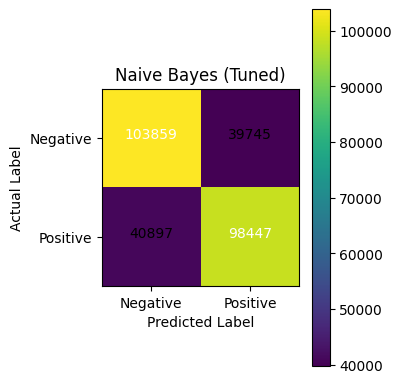

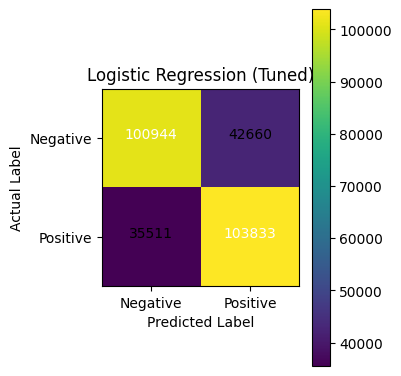

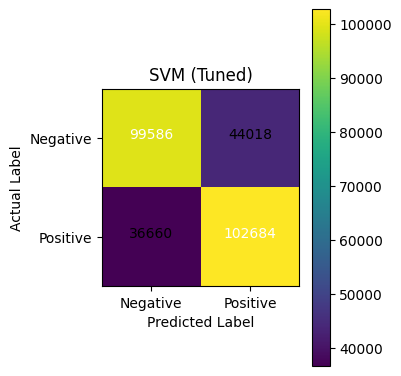

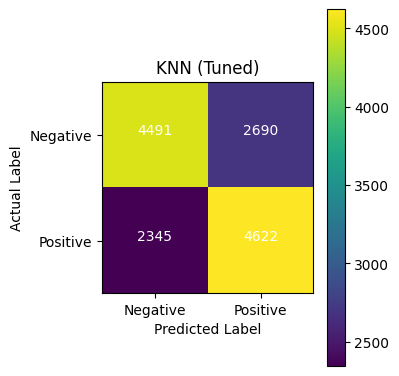

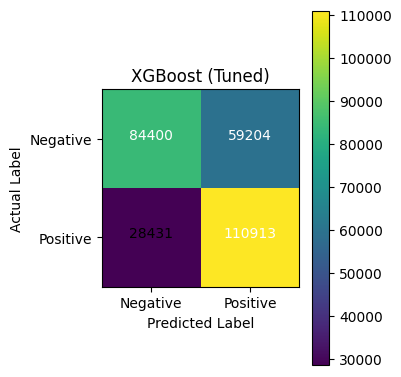

In [110]:
plot_confusion_matrix(nb_tuned_cm, "Naive Bayes (Tuned)")
plot_confusion_matrix(lr_tuned_cm, "Logistic Regression (Tuned)")
plot_confusion_matrix(svm_tuned_cm, "SVM (Tuned)")
plot_confusion_matrix(knn_tuned_cm, "KNN (Tuned)")
plot_confusion_matrix(xgb_tuned_cm, "XGBoost (Tuned)")


In [111]:
# ===============================
# MODEL COMPARISON & BEST MODEL SELECTION (CODE ONLY)
# ===============================

import pandas as pd

# ------------------------------------------------
# ASSUMPTION:
# The following variables already exist from evaluation:
# Baseline:
# nb_acc, lr_acc, svm_acc, knn_acc, xgb_acc
#
# Tuned:
# nb_tuned_acc, lr_tuned_acc, svm_tuned_acc, knn_tuned_acc, xgb_tuned_acc
# ------------------------------------------------

# -------------------------------
# 1. Create Comparison Table
# -------------------------------

comparison_df = pd.DataFrame({
    "Model": [
        "Naive Bayes",
        "Logistic Regression",
        "SVM",
        "KNN",
        "XGBoost"
    ],
    "Baseline Accuracy": [
        nb_acc,
        lr_acc,
        svm_acc,
        knn_acc,
        xgb_acc
    ],
    "Tuned Accuracy": [
        nb_tuned_acc,
        lr_tuned_acc,
        svm_tuned_acc,
        knn_tuned_acc,
        xgb_tuned_acc
    ]
})

# Accuracy improvement
comparison_df["Accuracy Gain"] = (
    comparison_df["Tuned Accuracy"] - comparison_df["Baseline Accuracy"]
)

print("\nMODEL COMPARISON TABLE\n")
print(comparison_df)

# -------------------------------
# 2. Decide Best Model
#    (Based on Tuned Accuracy)
# -------------------------------

best_model_row = comparison_df.loc[
    comparison_df["Tuned Accuracy"].idxmax()
]

best_model_name = best_model_row["Model"]
best_model_accuracy = best_model_row["Tuned Accuracy"]

print("\nBEST MODEL SELECTION\n")
print("Best Model:", best_model_name)
print("Tuned Accuracy:", round(best_model_accuracy, 4))

# -------------------------------
# 3. Map Best Model to Object
# -------------------------------

best_model_map = {
    "Naive Bayes": best_nb,
    "Logistic Regression": best_lr,
    "SVM": best_svm,
    "KNN": best_knn,
    "XGBoost": best_xgb
}

final_best_model = best_model_map[best_model_name]

print("\nFinal best model object ready for deployment.")



MODEL COMPARISON TABLE

                 Model  Baseline Accuracy  Tuned Accuracy  Accuracy Gain
0          Naive Bayes           0.713541        0.714994       0.001453
1  Logistic Regression           0.722910        0.723727       0.000816
2                  SVM           0.710996        0.714866       0.003870
3                  KNN           0.635779        0.644119       0.008340
4              XGBoost           0.682535        0.690279       0.007743

BEST MODEL SELECTION

Best Model: Logistic Regression
Tuned Accuracy: 0.7237

Final best model object ready for deployment.


In [112]:
# =========================================================
# FINAL SENTIMENT PREDICTION SYSTEM (STRICTLY FOLLOWED)
# - Final polarity model: Logistic Regression (binary)
# - Neutral handled ONLY by online RoBERTa model
# =========================================================

# -------------------------------
# 1. Load Neutral Detection Model
# -------------------------------

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

NEUTRAL_MODEL = "cardiffnlp/twitter-roberta-base-sentiment"

neutral_tokenizer = AutoTokenizer.from_pretrained(NEUTRAL_MODEL)
neutral_model = AutoModelForSequenceClassification.from_pretrained(NEUTRAL_MODEL)

NEUTRAL_LABELS = ["negative", "neutral", "positive"]

def detect_neutral(text):
    inputs = neutral_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding=True
    )
    with torch.no_grad():
        outputs = neutral_model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=1)
    return NEUTRAL_LABELS[torch.argmax(probs).item()]

# ---------------------------------------------------
# 2. Load FINAL POLARITY MODEL (Logistic Regression)
# ---------------------------------------------------
# ASSUMPTION:
# - tfidf vectorizer is already loaded as `tfidf`
# - tuned Logistic Regression is loaded as `best_lr`
# - preprocessing functions exist:
#   clean_and_normalize_text()
#   improved_pos_filter()

trained_model = best_lr   # FINAL MODEL (STRICT REQUIREMENT)

# ---------------------------------------------------
# 3. Unified Sentiment Prediction Function
# ---------------------------------------------------

def predict_sentiment(text):
    """
    Final sentiment prediction:
    1) Detect NEUTRAL using RoBERTa
    2) If not neutral → binary polarity via Logistic Regression
    """

    # ---------- A. Neutral Detection ----------
    neutral_result = detect_neutral(text)
    if neutral_result == "neutral":
        return "neutral"

    # ---------- B. Polarity Detection ----------
    tokens = clean_and_normalize_text(text)
    pos_tokens = improved_pos_filter(tokens)
    pos_text = " ".join(pos_tokens)

    # Safety check
    if pos_text.strip() == "":
        return "neutral"

    # Vectorization
    X = tfidf.transform([pos_text])

    # Logistic Regression Prediction
    return trained_model.predict(X)[0]




config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [117]:
# ---------------------------------------------------
# 4. User Input (Interactive Test)
# ---------------------------------------------------

text = input("Enter the text for Analysis: ")
print("Predicted Sentiment:", predict_sentiment(text))

Enter the text for Analysis: good work
Predicted Sentiment: positive


In [119]:
import ipywidgets as widgets
from IPython.display import display

text_area = widgets.Textarea(
    placeholder='Enter your text for sentiment analysis...',
    description='Text:',
    layout=widgets.Layout(width='700px', height='200px')
)

button = widgets.Button(description="Predict Sentiment")

output = widgets.Output()

def on_button_click(b):
    with output:
        output.clear_output()
        text = text_area.value
        result = predict_sentiment(text)
        print("Predicted Sentiment:", result)

button.on_click(on_button_click)

display(text_area, button, output)


Textarea(value='', description='Text:', layout=Layout(height='200px', width='700px'), placeholder='Enter your …

Button(description='Predict Sentiment', style=ButtonStyle())

Output()